In [ ]:
from alive_progress import alive_bar
import pandas as pd
import xarray as xr
import s3fs
import os

fs = s3fs.S3FileSystem(anon=True)
appended_data = []
start_year = 2015
end_year = 2059
climate_type = ['solar', 'wind', 'trh']
attr = ['ghi', 'windspeed_10m', 'temperature_2m']
climate_attr_dict = {climate_type: attr for climate_type, attr in zip(climate_type, attr)}
climate_type_num = len(['solar', 'wind', 'trh'])
year_num = len(range(start_year, end_year + 1))
loop_total_num = year_num * climate_type_num
cloud_type = "s3://"
bucket = "nrel-pds-sup3rcc/"
folder = "conus_mriesm20_ssp585_r1i1p1f1/"
version = "v0.1.0/"
file_base = "sup3rcc_conus_mriesm20_ssp585_r1i1p1f1"
file_extension = "h5"
URI_base = os.path.join(cloud_type, bucket, folder, version, file_base)

with alive_bar(loop_total_num, force_tty=True, title='Running', length=20, bar = 'smooth') as bar:

    for climate in climate_type:
        
        for year in range(start_year, end_year + 1):
    
            URI = f"{URI_base}_{climate}_{year}.{file_extension}"
            ds = xr.open_dataset(fs.open(URI), backend_kwargs={"phony_dims": "sort"}, engine='h5netcdf')
            time_index = pd.to_datetime(ds['time_index'][...].astype(str))
            meta = pd.DataFrame(ds.meta.data)
            WV_MarionCounty_index = meta[(meta['state'] == b'West Virginia') & (meta['county'] == b'Marion')].index[0]
            attr = [v for k, v in new_dict.items() if climate == k]
            attr = ','.join(map(str, attr))
            subset = ds[attr][:, WV_MarionCounty_index].load()
            data = pd.DataFrame({f"{attr}" : subset}, index = time_index)
            appended_data.append(data)
            bar()

final_data = pd.concat(appended_data)
group_data = final_data.groupby(final_data.index.year).mean()
group_data.head()

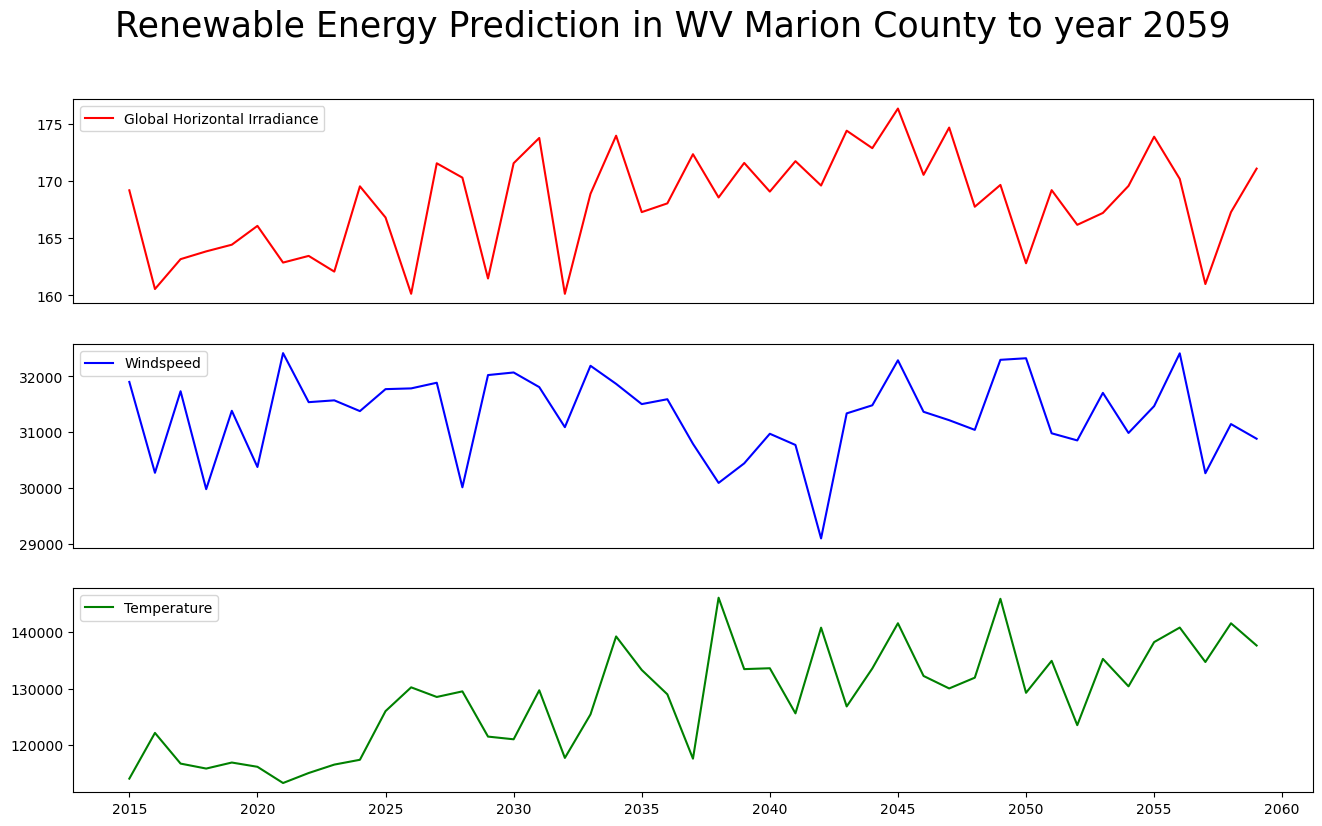

In [67]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, figsize=(16,9), sharex=True)
fig.suptitle('Renewable Energy Prediction in WV Marion County to year 2059', fontsize = 25)
axs[0].plot(group_data.ghi, color = 'r', label = "Global Horizontal Irradiance")
axs[0].legend(loc="upper left")
axs[0].get_xaxis().set_visible(False)
axs[1].plot(group_data.windspeed_10m, color = 'b', label = "Windspeed")
axs[1].legend(loc="upper left")
axs[1].get_xaxis().set_visible(False)
axs[2].plot(group_data.temperature_2m, color = 'g', label = "Temperature")
axs[2].legend(loc="upper left")
plt.xticks(range(2015, 2065, 5))
#plt.savefig("Renewable Energy Prediction.png") 
plt.show()